# Needed libraries

In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import os
import numpy as np
#import requests
import json

from galaxyGenius.config import Configuration
from galaxyGenius.preprocess import PreProcess
from galaxyGenius.generation import DataGeneration
from galaxyGenius.postprocess import PostProcess

dataDir = '../data/GalaxyGenius/'
os.environ['GALAXYGENIUS_DATA_DIR'] = '/home/mdelosrios/galaxyGenius/Data/'

/home/mdelosrios/miniconda3/envs/galaxygenius/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom functions

In [2]:
def custom_serialier(obj):
    
    '''
    Custom serializer for json dump
    
    Args:
        obj: object to be serialized
        
    Returns:
        obj: serialized object
    '''
    
    if isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, object):
        return str(obj)
    else:
        return obj

In [3]:
def add_random_views(inclinations, azimuths):
    # Nombre del archivo
    nombre_archivo = "run/skirt.ski"

    n_random_views = len(inclinations)
    random_views = []
    for i in range(n_random_views):
        # Nuevas líneas que quieres agregar
        random_views.append(
             f'<FullInstrument instrumentName="view_0{i+2}" distance="0 Mpc" inclination="{inclinations[i]} deg" azimuth="{azimuths[i]} deg" roll="0 deg" fieldOfViewX="149018.7230866075 pc" numPixelsX="1496" centerX="0 pc" fieldOfViewY="149018.7230866075 pc" numPixelsY="1496" centerY="0 pc" recordComponents="false" numScatteringLevels="0" recordPolarization="false" recordStatistics="false"> \n'
        )
        random_views.append(     '                       <wavelengthGrid type="WavelengthGrid"> \n',)
        random_views.append(     '                           <LinWavelengthGrid minWavelength="0.10600000157952309 micron" maxWavelength="1.2720000505447389 micron" numWavelengths="300"/> \n',)
        random_views.append(     '                       </wavelengthGrid> \n',)
        random_views.append(     '                   </FullInstrument> \n',)
        random_views.append(     '\n')   
        
    # Leer todo el contenido
    with open(nombre_archivo, "r", encoding="utf-8") as f:
        lineas = f.readlines()

    # Insertar a partir de la línea 50 (índice 49, ya que empieza en 0)
    lineas[48:48] = random_views  # Inserta sin eliminar
    
    # Reescribir el archivo completo
    with open(nombre_archivo, "w", encoding="utf-8") as f:
        f.writelines(lineas)
    
    return None

# TNG

In [34]:
config_files = Path('.').glob('config*.toml')
for file in config_files:
    os.remove(file)

In [35]:
# Initialize configuration
config = Configuration()
conf = config.get_config()

No conflicts in configurations. 👍


In [36]:
# add CSST and HSC surveys
config.add_survey('CSST,HSC')
conf = config.get_config()

CSST added.
HSC added.
No conflicts in configurations. 👍


In [37]:
# manually save config
config.save_config(conf)

In [38]:
conf['requests'] = True
conf['apiKey'] = '81b7c70637fa8b110e6b9f236ea07c37'
conf['numViews'] = 3
conf['faceAndEdge'] = True
conf['minStellarMass'] = 1e10
conf['maxStellarMass'] = 1e12
conf['snapNum'] = 99

In [39]:
conf

{'requests': True,
 'apiKey': '81b7c70637fa8b110e6b9f236ea07c37',
 'simulation': 'TNG100-1',
 'hydrodynamicSolver': 'VoronoiMesh',
 'TNGPath': '../../TNG100',
 'postprocessingPath': '../../postprocessing',
 'workingDir': 'run',
 'simulationMode': 'NoMedium',
 'includeDust': False,
 'dustEmissionType': 'Equilibrium',
 'dustModel': 'ZubkoDustMix',
 'minWavelength': 0.1,
 'maxWavelength': 1.2,
 'boxLengthScale': 20,
 'maxBoxLength': 300,
 'fieldOfView': 0,
 'wavelengthGrid': 'Linear',
 'numWavelengths': 300,
 'minLevel': 6,
 'maxLevel': 10,
 'numPackets': 10000000.0,
 'SEDFamily': 'BC03',
 'initialMassFunction': 'Chabrier',
 'minStellarMass': 10000000000.0,
 'maxStellarMass': 1000000000000.0,
 'estimateMorph': False,
 'faceAndEdge': True,
 'numViews': 3,
 'randomViews': True,
 'inclinations': [0, 90, 180],
 'azimuths': [0, 90, 180],
 'postProcessing': True,
 'spatialResol': 100,
 'imageUnit': 'electron',
 'surveys': ['CSST', 'HSC'],
 'displaySED': True,
 'displaySEDxlogscale': True,
 'out

In [40]:
# Initialize PreProcess
preprocess = PreProcess(conf)

In [41]:
# Get subhalos following conditions indicated in conf
subhalos_gg = preprocess.get_subhalos()

# Equivalent to:
#            subhalos = get(subhalos_url, {'limit': N, 'offset': 0,
#                          'mass_stars__gt': star_mass_min, 'mass_stars__lt': star_mass_max,
#                          'subhaloflag__gt':0})

Requesting time taken: 37.69 seconds
6463 subhalos in snapshot 99 in stellar mass from 10^10.00 to 10^12.00 [M_sun]


In [42]:
len(np.where(np.asarray(preprocess.subhaloSFR) >= 0.1)[0])

4217

In [43]:
dir(preprocess)

['_PreProcess__calculate_angular_momentum_and_angles',
 '_PreProcess__create_ski',
 '_PreProcess__estimate_morphology',
 '_PreProcess__fage',
 '_PreProcess__get_particles',
 '_PreProcess__get_properties',
 '_PreProcess__get_properties_survey',
 '_PreProcess__init',
 '_PreProcess__make_request_with_retry',
 '_PreProcess__precompile_numba',
 '_PreProcess__read_subhalos',
 '_PreProcess__read_temp_file',
 '_PreProcess__retrieve_subhalos_with_requests',
 '_PreProcess__save_configs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'angular_momentum',
 'base_url',
 'config',
 'cosmology',
 'dataDir',
 'fage',
 'get_subhalos',
 'h',
 'headers',
 'inputs'

In [44]:
preprocess.config

{'requests': True,
 'apiKey': '81b7c70637fa8b110e6b9f236ea07c37',
 'simulation': 'TNG100-1',
 'hydrodynamicSolver': 'VoronoiMesh',
 'TNGPath': '../../TNG100',
 'postprocessingPath': '../../postprocessing',
 'workingDir': 'run',
 'simulationMode': 'NoMedium',
 'includeDust': False,
 'dustEmissionType': 'Equilibrium',
 'dustModel': 'ZubkoDustMix',
 'minWavelength': 0.1,
 'maxWavelength': 1.2,
 'boxLengthScale': 20,
 'maxBoxLength': 300,
 'fieldOfView': 0,
 'wavelengthGrid': 'Linear',
 'numWavelengths': 300,
 'minLevel': 6,
 'maxLevel': 10,
 'numPackets': 10000000.0,
 'SEDFamily': 'BC03',
 'initialMassFunction': 'Chabrier',
 'minStellarMass': 10000000000.0,
 'maxStellarMass': 1000000000000.0,
 'estimateMorph': False,
 'faceAndEdge': True,
 'numViews': 3,
 'randomViews': True,
 'inclinations': [0, 90, 180],
 'azimuths': [0, 90, 180],
 'postProcessing': True,
 'spatialResol': 100,
 'imageUnit': 'electron',
 'surveys': ['CSST', 'HSC'],
 'displaySED': True,
 'displaySEDxlogscale': True,
 'out

In [45]:
preprocess.subhalo(subhaloID=550305)

Subhalo URL:  http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/550305/
Requesting time taken: 6.71 seconds
Stellar Mass of Subhalo 550305 is 10^10.08 [M_sun].
SFR of Subhalo 550305 is 2.53 [M_sun/yr].


In [66]:
# Preparation of files for SKIRT to run
preprocess.prepare()

Retrieving Stellar and Gas particles.
Requesting time taken: 50.16 seconds
Starforming regions:  1075
Stars:  10739
Creating .ski file.
------Calculating face-on and edge-on viewing angles------
Face-on angle: (106.30200585374382, 57.13017434456485)
Edge-on angle: (160.8016840697058, -90.0)
View 0: Inclination = 106.30 deg, Azimuth = 57.13 deg
View 1: Inclination = 160.80 deg, Azimuth = -90.00 deg
------estimate memory usage------
numViews: 2
numSpatialPixels: 1496
numWavelengthPixels: 300
Estimated memory usage: 10.742 GB


In [75]:
add_random_views(inclinations = [160], azimuths =[-45])

In [73]:
with open('run/properties.json', 'r') as file:
            properties = json.load(file)

properties['inclinations'].append(160)
properties['azimuths'].append(-45)
properties['numViews'] = 3

with open('run/properties.json', 'w') as file:
            json.dump(properties, file, 
                      default=custom_serialier, indent=4)

In [76]:
with open('run/config.json', 'r') as file:
            config = json.load(file)

config['inclinations'].append(160)
config['azimuths'].append(-45)
config['numViews'] = 3

with open('run/config.json', 'w') as file:
            json.dump(config, file, 
                      default=custom_serialier, indent=4)

In [77]:
conf['inclinations'].append(160)
conf['azimuths'].append(-45)
conf['numViews'] = 3

In [78]:
dataGeneration = DataGeneration(config=conf)

In [80]:
dataGeneration.runSKIRT()

Running SKIRT
Subhalo ID:  550305
06/10/2025 14:21:16.127   Welcome to SKIRT v9.0 (git 5259971 built on 22/09/2025 at 14:21:33)
06/10/2025 14:21:16.127   Running on milan01 for mdelosrios
06/10/2025 14:21:16.127   Constructing a simulation from ski file 'skirt.ski'...
06/10/2025 14:21:20.658   Starting simulation skirt using 12 threads and a single process...
06/10/2025 14:21:20.658   Starting setup...
06/10/2025 14:21:20.658     Panchromatic wavelength regime
06/10/2025 14:21:20.658     No transfer medium
06/10/2025 14:21:20.658     Redshift: 0.06
06/10/2025 14:21:20.658     Luminosity distance: 277.531 Mpc
06/10/2025 14:21:20.658     Model symmetry: 3D
06/10/2025 14:21:20.662   BruzualCharlotSEDFamily opened stored table /home/mdelosrios/SKIRT/resources/SKIRT9_Resources_Core/SED/BruzualCharlotSEDFamily_Chabrier_hr.stab
06/10/2025 14:21:20.663   ParticleSource reads smoothed source particles from text file /home/mdelosrios/trabajos/MaDaMe/codes/run/stars.txt...
06/10/2025 14:21:20.664

0

In [81]:
# Initialize PostProcess
postprocess = PostProcess(subhaloID=550305)

Run Postprocessing
Begin postprocessing for CSST


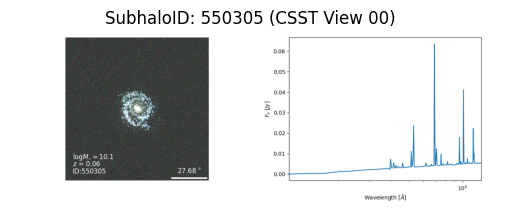

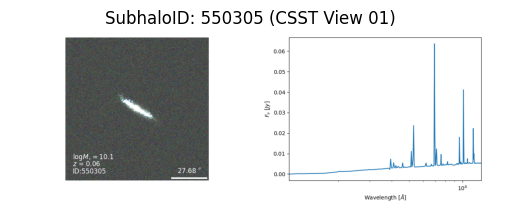

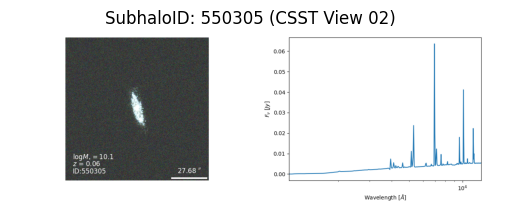

Finish postprocessing for CSST
Time taken to postprocess for CSST: 30.54 seconds
Begin postprocessing for HSC


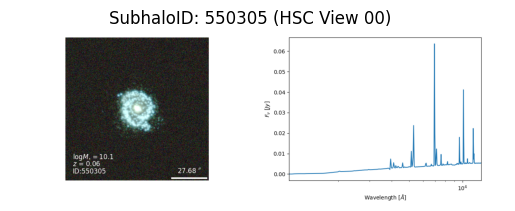

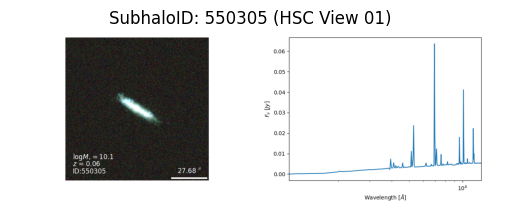

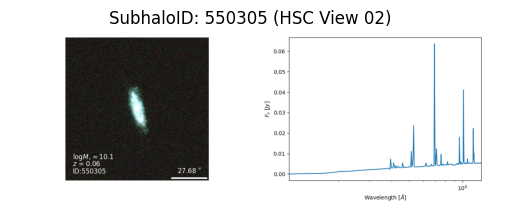

Finish postprocessing for HSC
Time taken to postprocess for HSC: 8.14 seconds


In [84]:
# Run postprocessing
postprocess.runPostprocess(showImages=True)

In [85]:
from astropy.io import fits


In [86]:

# Abrir el archivo FITS
archivo = "mock_CSST/Subhalo_550305/galaxy_images.fits"
hdul = fits.open(archivo)

# Ver información general del archivo
hdul.info()

Filename: mock_CSST/Subhalo_550305/galaxy_images.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 ImageHDU        33   (1496, 1496, 3)   float32   
  2                1 ImageHDU        33   (1496, 1496, 3)   float32   
  3                1 ImageHDU        33   (1496, 1496, 3)   float32   
  4                1 ImageHDU        33   (1496, 1496, 3)   float32   
  5                1 ImageHDU        33   (1496, 1496, 3)   float32   
  6                1 ImageHDU        33   (1496, 1496, 3)   float32   
  7                1 ImageHDU        33   (1496, 1496, 3)   float32   


In [92]:
imagen_data = hdul[1].data

In [103]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1496                                                  
NAXIS2  =                 1496                                                  
NAXIS3  =                    3                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
SNAPNUM =                   99 / Snapshot ID                                    
ID      =               550305 / Subhalo ID                                     
MASS    =   10.081040248606117 / Subhalo stellar mass, in log10 scale (Msun)    
SURVEY  = 'CSST    '           / Survey                                         
NFILTERS=                   

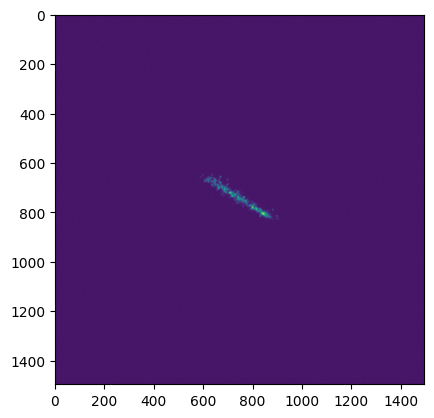

In [151]:
plt.imshow(imagen_data[1,:,:])

In [99]:
import matplotlib.pyplot as plt

In [147]:
x_ang_mom = np.sin(conf['inclinations'][1]) * np.cos(conf['azimuths'][1])
y_ang_mom = np.sin(conf['inclinations'][1]) * np.sin(conf['azimuths'][1])
z_ang_mom = np.cos(conf['inclinations'][1])

In [117]:
(x_ang_mom**2)+(y_ang_mom**2)+(z_ang_mom**2)

1.0

In [123]:
def rotation_to_k(v, k = np.array([0.0, 0.0, 1.0])):
    """
    Devuelve la matriz de rotación R (3x3) tal que R @ v_unit = [0,0,1].
    v can be any 3-vector; function normaliza internamente.
    """
    v = np.asarray(v, dtype=float)
    norm = np.linalg.norm(v)
    if norm == 0:
        raise ValueError("El vector no puede ser el vector cero.")
    v = v / norm

    # Producto cruz y coseno
    a = np.cross(v, k)
    s = np.linalg.norm(a)
    c = np.dot(v, k)

    # Caso: ya apunta a +z
    if s < 1e-12 and c > 0.999999:
        return np.eye(3)

    # Caso: apunta a -z (rotación de pi)
    if s < 1e-12 and c < -0.999999:
        # elegir un eje perpendicular a v
        if abs(v[0]) < 0.9:
            axis = np.array([1.0, 0.0, 0.0])
        else:
            axis = np.array([0.0, 1.0, 0.0])
        axis = axis - axis.dot(v) * v      # hacer perpendicular a v
        axis = axis / np.linalg.norm(axis) # normalizar
        # Rodrigues con theta = pi
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + 2 * K.dot(K)   # porque sin(pi)=0, 1-cos(pi)=2 -> R = I + K^2 * 2
        return R

    # Caso general
    axis = a / s
    theta = np.arctan2(s, c)  # ángulo entre v y k
    ax, ay, az = axis
    K = np.array([[0, -az, ay],
                  [az, 0, -ax],
                  [-ay, ax, 0]])
    R = np.eye(3) + K * np.sin(theta) + (K @ K) * (1 - np.cos(theta))
    return R

In [148]:
# Ejemplo
v = np.array([x_ang_mom, y_ang_mom, z_ang_mom])  # ejemplo (aprox unitario)
Rz = rotation_to_k(v, k = np.array([0.0, 0.0, 1.0]))
print("R @ v =", Rz @ (v / np.linalg.norm(v)))  # debería acercarse a [0,0,1]
print("Determinante R:", np.linalg.det(Rz))    # debería ser +1

R @ v = [1.17886804e-16 1.48706140e-16 1.00000000e+00]
Determinante R: 0.9999999999999998


In [139]:
v = np.array([x_ang_mom, y_ang_mom, z_ang_mom])  # ejemplo (aprox unitario)
Ry = rotation_to_k(v, k = np.array([0.0, 1.0, 0.0]))
print("R @ v =", Ry @ (v / np.linalg.norm(v)))  # debería acercarse a [0,0,1]
print("Determinante R:", np.linalg.det(Ry)) 

R @ v = [ 4.70789787e-17  1.00000000e+00 -1.30810402e-16]
Determinante R: 1.0


In [140]:
v = np.array([x_ang_mom, y_ang_mom, z_ang_mom])  # ejemplo (aprox unitario)
Rx = rotation_to_k(v, k = np.array([1.0, 0.0, 0.0]))
print("R @ v =", Rx @ (v / np.linalg.norm(v)))  # debería acercarse a [0,0,1]
print("Determinante R:", np.linalg.det(Rx)) 

R @ v = [ 1.00000000e+00 -5.54583380e-17 -1.15115646e-17]
Determinante R: 1.0


In [134]:
R

array([[ 0.77054499,  0.40950145,  0.48843523],
       [-0.40950145, -0.26917507,  0.87169567],
       [ 0.48843523, -0.87169567, -0.03972006]])

In [105]:
import numpy as np
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import CubicSplineKernel
import astropy.units as U

In [107]:
from getpass import getpass

api_key = getpass("TNG web API key:")

TNG web API key: ········


In [108]:
simulation = "TNG100-1"
snapshot = 99
subhalo_id = 550305  

In [141]:
sourcex = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=4 * U.Mpc,
    rotation={"rotmat": Rx},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

Using local cutout file martini-cutout-TNG100-1-99-3486.hdf5


In [143]:
sourcey = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=4 * U.Mpc,
    rotation={"rotmat": Ry},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

Using local cutout file martini-cutout-TNG100-1-99-3486.hdf5


In [162]:
sourcez = TNGSource(
    simulation,
    snapshot,
    subhalo_id,
    api_key=api_key,
    cutout_dir=".",
    distance=4 * U.Mpc,
    rotation={"rotmat": Rz},
    ra=0.0 * U.deg,
    dec=0.0 * U.deg,
)

Using local cutout file martini-cutout-TNG100-1-99-3486.hdf5


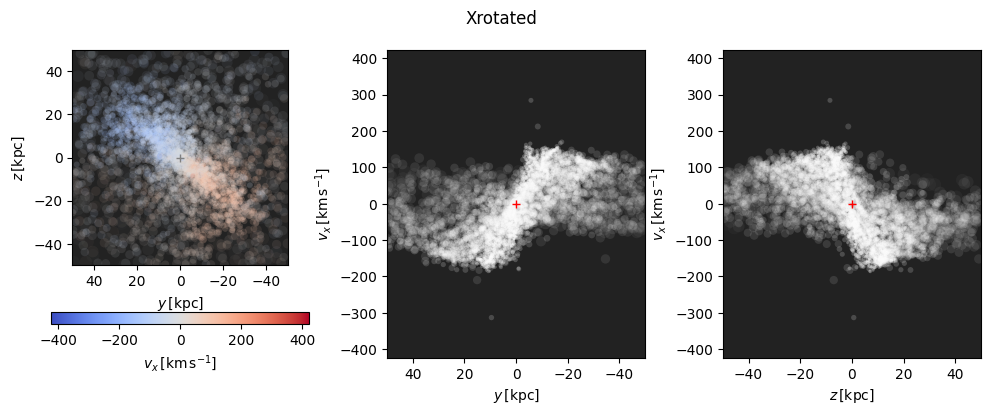

In [150]:
preview_fig_rotated = sourcex.preview(title="Xrotated",lim=50 * U.kpc)

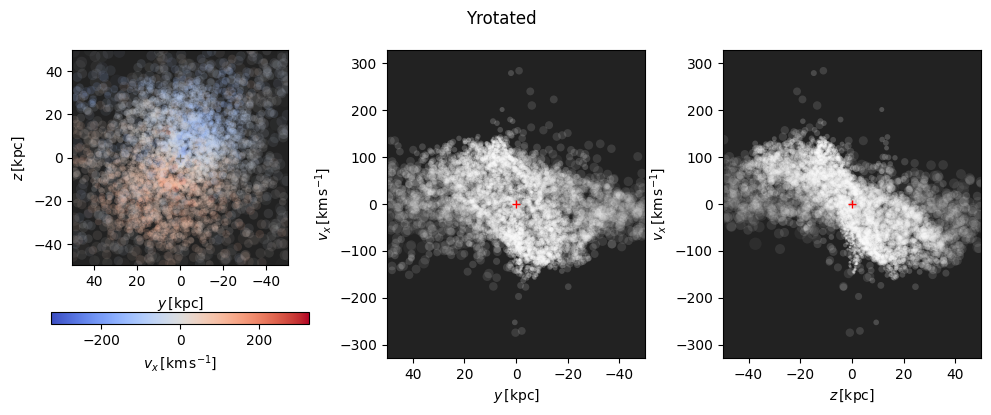

In [145]:
preview_fig_rotated = sourcey.preview(title="Yrotated",lim=50 * U.kpc)

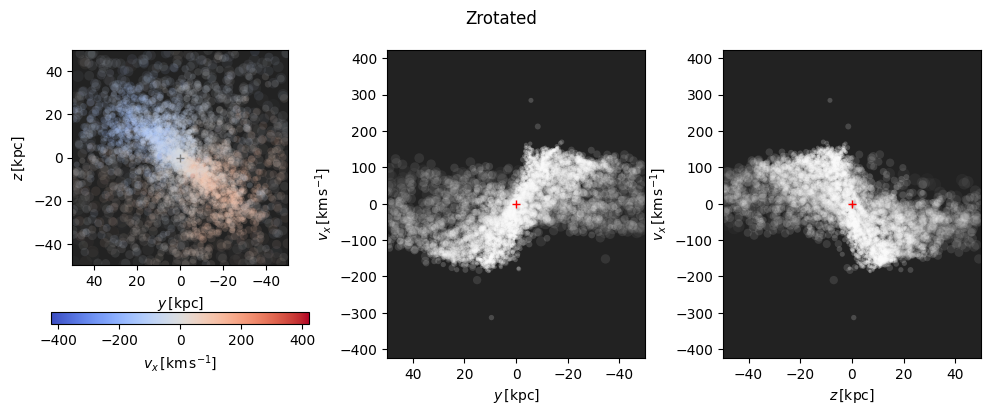

In [163]:
preview_fig_rotated = sourcez.preview(title="Zrotated",lim=50 * U.kpc)


In [164]:
beam = GaussianBeam(
    bmaj = 30.0 * U.arcsec, bmin=30.0 * U.arcsec, bpa=0.0 * U.deg, truncate=3.0
)

noise = GaussianNoise(
    rms = 3.0e-8 * U.Jy * U.beam**-1
)

spectral_model = GaussianSpectrum(sigma = "thermal")

sph_kernel = CubicSplineKernel()

In [165]:
datacube = DataCube(
    n_px_x=384,
    n_px_y=384,
    n_channels=50,
    px_size=10.0 * U.arcsec,
    channel_width=16.0 * U.km * U.s**-1,
    velocity_centre=sourcez.vsys,
    ra=source.ra,
    dec=source.dec,
)

In [166]:
M = Martini(
    source=sourcez,
    datacube=datacube,
    beam=beam,
    noise=noise,
    spectral_model=spectral_model,
    sph_kernel=sph_kernel,
)

Source module contained 42806 particles with total HI mass of 1.79e+10 solMass.
Pruned particles that will not contribute to data cube, 25328 particles remaining with total HI mass of 1.57e+10 solMass.


In [167]:
ncpu = 10
M.insert_source_in_cube(ncpu=ncpu)
M.add_noise()
M.convolve_beam()

Exception ignored in: <function tqdm.__del__ at 0x7f7defb83060>
Traceback (most recent call last):
  File "/home/mdelosrios/miniconda3/envs/galaxygenius/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/mdelosrios/miniconda3/envs/galaxygenius/lib/python3.11/site-packages/tqdm/notebook.py", line 284, in close
    self.disp(close=True, check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|███████████████████████████████████████████████| 163216/163216 [00:55<00:00, 2946.78it/s]


Source inserted.
  Flux density in cube: 2.60e+02 Jy
  Mass in cube (assuming distance 4.00 Mpc and a spatially resolved source): 1.57e+10 solMass
    [88% of initial source mass]
  Maximum pixel: 1.18e-04 Jy / arcsec2
  Median non-zero pixel: 9.58e-15 Jy / arcsec2
Noise added.
  Noise cube RMS: 1.46e-10 Jy / arcsec2 (before beam convolution).
  Data cube RMS after noise addition (before beam convolution): 2.68e-06 Jy / arcsec2
Beam convolved.
  Data cube RMS after beam convolution: 2.83e-03 Jy / beam
  Maximum pixel: 1.12e-01 Jy / beam
  Median non-zero pixel: 3.58e-08 Jy / beam


In [168]:
M.write_fits("tng_martini_demo.fits")
M.write_beam_fits("tng_martini_demo_beam.fits")
M.write_hdf5("tng_martini_demo.hdf5")

In [174]:
from astropy.wcs import WCS

with fits.open("tng_martini_demo.fits") as f:
    cube_wcs = WCS(f[0].header)
    flux_cube = f[0].data * U.Unit(f[0].header["BUNIT"])
    n_channels = cube_wcs.pixel_shape[cube_wcs.wcs.spec]
    vch = np.array(cube_wcs.sub(axes=[3]).all_pix2world(np.arange(n_channels), 0))[
        0
    ] * U.Unit(cube_wcs.world_axis_units[cube_wcs.wcs.spec])
    vch = vch - source.vsys

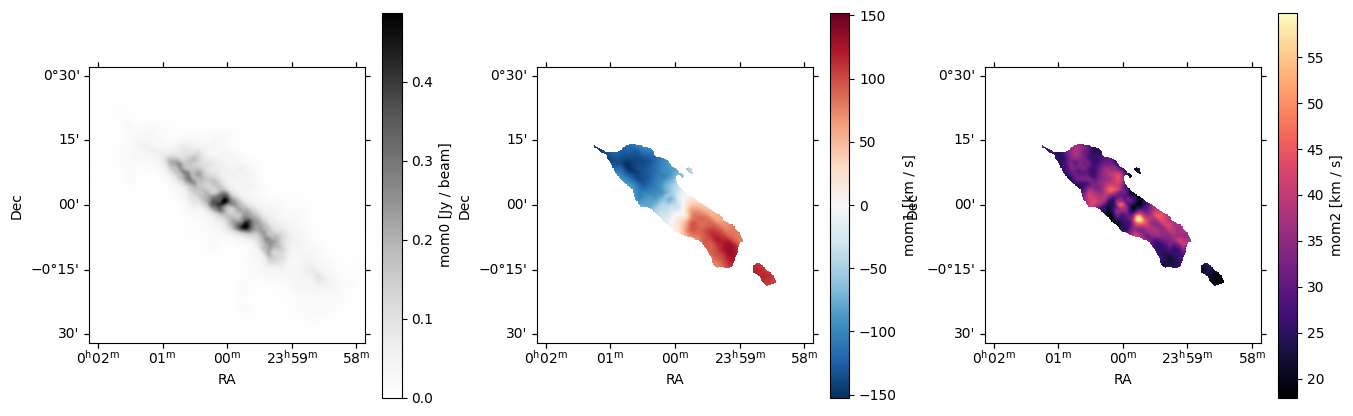

In [176]:
# choose plotting units
mom0_unit = U.Jy / U.beam
mom1_unit = U.km / U.s
mom2_unit = U.km / U.s

rms = np.std(
    flux_cube[:, :16, :16]
)  # noise in a corner patch where there is little signal
clip = np.where(flux_cube > 5 * rms, 1, 0)
np.seterr(all="ignore")
fig = plt.figure(figsize=(16, 5))
plt.clf()
sp1 = fig.add_subplot(1, 3, 1, aspect="equal", projection=cube_wcs.celestial)
sp2 = fig.add_subplot(1, 3, 2, aspect="equal", projection=cube_wcs.celestial)
sp3 = fig.add_subplot(1, 3, 3, aspect="equal", projection=cube_wcs.celestial)
mom0 = np.sum(flux_cube, axis=0)
mask = np.where(mom0 > 0.05 * U.Jy / U.beam, 1, np.nan)
mom1 = np.sum(flux_cube * clip * vch[:, np.newaxis, np.newaxis], axis=0) / mom0
mom2 = np.sqrt(
    np.sum(
        flux_cube
        * clip
        * np.power(vch[:, np.newaxis, np.newaxis] - mom1[np.newaxis], 2),
        axis=0,
    )
    / mom0
)
im1 = sp1.imshow(mom0.to_value(mom0_unit), cmap="Greys")
plt.colorbar(im1, ax=sp1, label=f"mom0 [{mom0_unit}]")
im2 = sp2.imshow(
    (mom1 * mask).to_value(mom1_unit),
    cmap="RdBu_r",
    vmin=-np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
    vmax=np.nanmax(np.abs(mom1 * mask)).to_value(mom1_unit),
)
plt.colorbar(im2, ax=sp2, label=f"mom1 [{mom1_unit}]")
im3 = sp3.imshow(
    (mom2 * mask).to_value(mom2_unit),
    cmap="magma",
)
plt.colorbar(im3, ax=sp3, label=f"mom2 [{mom2_unit}]")
for sp in sp1, sp2, sp3:
    sp.set_xlabel("RA")
    sp.set_ylabel("Dec")

plt.subplots_adjust(wspace=0.3)


# Eagle

In [6]:
import sys
sys.path.append('..')

import os
os.environ['GALAXYGENIUS_DATA_DIR'] = '/home/mdelosrios/galaxyGenius/Data'


from galaxyGenius.config import Configuration
from galaxyGenius.preprocess import PreProcess
from galaxyGenius.generation import DataGeneration
from galaxyGenius.postprocess import PostProcess
#from galaxyGenius.utils import Units

import numpy as np
from typing import Union
from astropy.cosmology import Planck13
import astropy.units as u
import astropy.constants as const
import os
import h5py
import pandas as pd

In [7]:
config = Configuration()
conf = config.get_config()
config.add_survey('CSST,HSC')
conf = config.get_config()

No conflicts in configurations. 👍
CSST already exists.
HSC already exists.
No conflicts in configurations. 👍


In [8]:
conf['simulation'] = 'EAGLE'
conf['snapNum'] = 27
conf['numThreads'] = 24
conf['snapRedshift'] = 0.101
conf['viewRedshift'] = 0.101
conf['includeDust'] = True
conf['dustModel'] = 'ThemisDustMix'
conf['simulationMode'] = 'ExtinctionOnly'
conf['hydrodynamicSolver'] = 'smoothParticle'
conf['numPackets'] = 1e6
conf['SEDFamily'] = 'FSPS'
conf['displaySEDxlogscale'] = False

In [9]:
config.save_config(conf)
conf = config.get_config()

No conflicts in configurations. 👍


In [11]:
import eagleSqlTools as sql

In [12]:
def build_query(keys: list, table_name: str, conditions: Union[list, None] = None, order_by: Union[str, None] = None):
    # Construct the SELECT clause with table alias
    alias = 'PROG'
    
    select_clause = ",\n    ".join([f"{alias}.{key}" for key in keys])
    query = f"SELECT\n    {select_clause}\nFROM\n    {table_name} AS {alias}"
    
    # Add WHERE conditions if provided
    if conditions:
        where_clause = " AND\n    ".join([f"{alias}.{key}" for key in conditions])
        query += f"\nWHERE\n    {where_clause}"
    
    # Add ORDER BY clause if provided
    if order_by:
        query += f"\nORDER BY\n    {alias}.{order_by}"
    
    return query

In [13]:
SubhaloKeys = [
    'GalaxyID', 'Redshift', 'MassType_Star',
    'CentreOfPotential_x', 'CentreOfPotential_y', 'CentreOfPotential_z',
    'HalfMassRad_Star', 'StarFormationRate'
]

SubhaloUnits = ['1', '1', 'Msun', 
         'cMpc', 'cMpc', 'cMpc',
         'pkpc', 'Msun/yr']

# Image_face and Image_edge are urls of galaxy images at face-on and edge-on views of EAGLE simulation.
# keys_imgs = ['Image_face', 'Image_edge']
# keys = keys + keys_imgs

table_name = "RefL0100N1504_Subhalo"
alias = "PROG"
conditions = ["Snapnum = 27", "MassType_Star > 1.0e10"]
order_by = "MassType_Star DESC"

# Generate the query
query = build_query(SubhaloKeys, table_name, conditions, order_by)
print(query)

SELECT
    PROG.GalaxyID,
    PROG.Redshift,
    PROG.MassType_Star,
    PROG.CentreOfPotential_x,
    PROG.CentreOfPotential_y,
    PROG.CentreOfPotential_z,
    PROG.HalfMassRad_Star,
    PROG.StarFormationRate
FROM
    RefL0100N1504_Subhalo AS PROG
WHERE
    PROG.Snapnum = 27 AND
    PROG.MassType_Star > 1.0e10
ORDER BY
    PROG.MassType_Star DESC
